In [26]:
import pandas as pd
import numpy as np
import scipy.sparse as sp

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.calibration import CalibratedClassifierCV
from sklearn.svm import LinearSVC
from sklearn.metrics import roc_auc_score, roc_curve

In [1]:
from xgboost.sklearn import XGBClassifier

In [6]:
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
%matplotlib inline

## Чтение

In [2]:
df_train = pd.read_csv('data/train.txt', sep='\t')

In [4]:
df_validate = pd.read_csv('data/validation.txt', sep='\t')

In [3]:
df_train.head()

,id,context,response,human-generated
0,0,<first_speaker> 9@@ 5 de@@ gre@@ es with <numb...,<second_speaker> <at> i forgot that thank@@ s@...,0
1,1,<first_speaker> <at> <at> y@@ ar ! o@@ y just ...,<first_speaker> <at> lol b we 'll see . we hea...,0
2,2,<first_speaker> ohh ! de@@ u cer@@ to ! ! dddd...,<second_speaker> <at> ac@@ or@@ de@@ i ag@@ or...,1
3,3,<first_speaker> ugh@@ hhh i wanted a pic@@ kle...,<second_speaker> <at> lol g@@ m,0
4,4,<first_speaker> <at> <at> <at> need to know to...,"<first_speaker> <at> ok , will do - don 't be ...",1


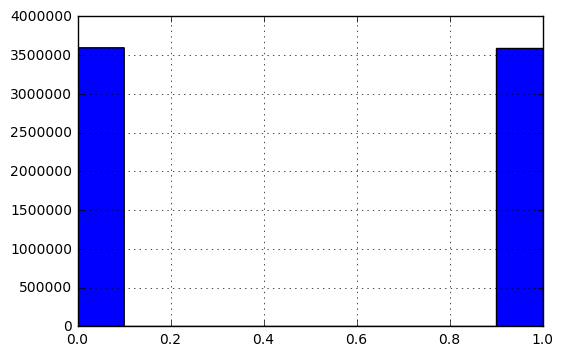

In [7]:
df_train['human-generated'].hist()

In [5]:
df_validate.head()

,id,context,response,human-generated
0,0,<first_speaker> morning <second_speaker> <at> ...,<first_speaker> <at> on the way to class,1
1,1,<first_speaker> c@@ loud compu@@ ting to drive...,<second_speaker> <at> except of course when th...,1
2,2,<first_speaker> my top followers <at> <at> <at...,<second_speaker> <at> it obviously doesn 't co...,1
3,3,<first_speaker> life so cold you 'll free@@ ze...,<second_speaker> <at> i like ur profile pic th...,1
4,4,<first_speaker> me and <at> <url> yi@@ kes ! o...,<third_speaker> <at> u going show <number> nite,1


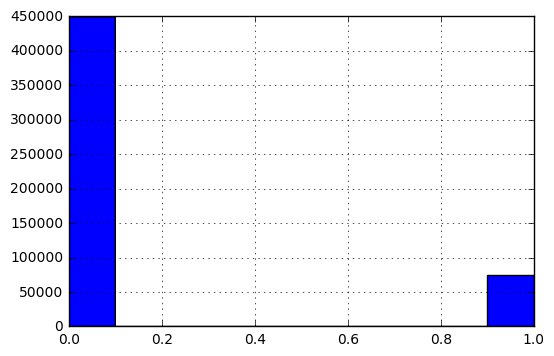

In [8]:
df_validate['human-generated'].hist()

In [ ]:
def train1(df_train, df_validate):
    cv = CountVectorizer(token_pattern=r'\S+', ngram_range=(1, 3), min_df=10, binary=True, dtype=np.uint8)
    
    X_train = cv.fit_transform(df_train.response)
    y_train = df_train['human-generated'].values

    X_validate = cv.transform(df_validate.response)
    y_validate = df_validate['human-generated'].values
    
    C = 0.01
    svm = LinearSVC(penalty='l1', dual=False, C=C, random_state=55)
    svm.fit(X_train, y_train)
    y_pred = svm.decision_function(X_validate)
    
    return roc_auc_score(y_validate, y_pred)

In [ ]:
def train2(df_train, df_validate):
    cv = CountVectorizer(token_pattern=r'\S+', ngram_range=(1, 3), min_df=10, binary=True, dtype=np.uint8)
    
    def repl(string):
        return string.replace('@@ ', '')
    
    X_train = cv.fit_transform(map(repl, df_train.response))
    y_train = df_train['human-generated'].values

    X_validate = cv.transform(map(repl, df_validate.response))
    y_validate = df_validate['human-generated'].values
    
    C = 0.01
    svm = LinearSVC(penalty='l1', dual=False, C=C, random_state=55)
    svm.fit(X_train, y_train)
    y_pred = svm.decision_function(X_validate)
    
    return roc_auc_score(y_validate, y_pred)

In [ ]:
def train3(df_train, df_validate, df_test):
    cv = CountVectorizer(token_pattern=r'\S+', ngram_range=(1, 3), min_df=150, binary=True, dtype=np.uint8)
    
    print("train: {}, validate: {}".format(df_train.shape, df_validate.shape))
    
    print("copy and concat")
    df_tmp = df_train.copy()
    df_tmp['response'] = df_train['context']
    df_tmp['human-generated'] = 1
    df_train = pd.concat((df_train, df_tmp))
    
    print("train: {}, validate: {}".format(df_train.shape, df_validate.shape))
    
    print("fit & transform")
    X_train = cv.fit_transform(df_train.response)
    y_train = df_train['human-generated'].values
    
    print("fit")
    C = 0.01
    svm = LinearSVC(penalty='l1', dual=False, C=C, random_state=55)
    svm.fit(X_train, y_train)
    
    print('validate')
    X_validate = cv.transform(df_validate.response)
    y_validate = df_validate['human-generated'].values
    y_pred = svm.decision_function(X_validate)
    print(roc_auc_score(y_validate, y_pred))
    
    print('test submit')
    X_test = cv.transform(df_test.response)
    y_pred = svm.decision_function(X_test)
    df_res = pd.DataFrame()
    df_res['id'] = df_test.id
    df_res['human-generated'] = y_pred

    df_res.to_csv('sub150.csv', index=False)
    
    return True

In [ ]:
def train_c(df_train, df_validate, df_test):
    cv = CountVectorizer(token_pattern=r'\S+', ngram_range=(1, 3), min_df=10, binary=True, dtype=np.uint8)
    
    X_train = cv.fit_transform(df_train.response)
    y_train = df_train['human-generated'].values
    
    C = 0.01
    svm = LinearSVC(penalty='l1', dual=False, C=C, random_state=55)
    svm.fit(X_train, y_train)
    
    X_validate = cv.transform(df_validate.response)
    y_validate = df_validate['human-generated'].values
    
    cclf = CalibratedClassifierCV(svm, cv='prefit')
    cclf.fit(X_validate, y_validate)
    
    X_test = cv.transform(df_test.response)
    y_pred = cclf.predict_proba(X_test)
    
    return y_pred[:, 1]

In [ ]:
def train_c2(df_train, df_validate, df_test):
    cv = CountVectorizer(token_pattern=r'\S+', ngram_range=(1, 3), min_df=10, binary=True, dtype=np.uint8)
    
    df_all = pd.concat((df_train, df_validate))
    
    X_train = cv.fit_transform(df_all.response)
    y_train = df_all['human-generated'].values
    
    C = 0.01
    svm = LinearSVC(penalty='l1', dual=False, C=C, random_state=55)
    
    cclf = CalibratedClassifierCV(svm, cv=3)
    cclf.fit(X_train, y_train)
    
    X_test = cv.transform(df_test.response)
    y_pred = cclf.predict_proba(X_test)
    
    return y_pred[:, 1]

max_depth=9, learning_rate=0.3, n_estimators=30: 0.730531301162
max_depth=9, learning_rate=0.3, n_estimators=40: 0.733016387935
max_depth=9, learning_rate=0.3, n_estimators=50: 0.734467133733
max_depth=9, learning_rate=0.35, n_estimators=30: 0.731940762131
max_depth=9, learning_rate=0.35, n_estimators=40: 0.734602830081
max_depth=9, learning_rate=0.35, n_estimators=50: 0.736967875947
max_depth=9, learning_rate=0.4, n_estimators=30: 0.7327362721
max_depth=9, learning_rate=0.4, n_estimators=40: 0.735523295579
max_depth=9, learning_rate=0.4, n_estimators=50: 0.737205045947
max_depth=12, learning_rate=0.3, n_estimators=30: 0.737724933709
max_depth=12, learning_rate=0.3, n_estimators=40: 0.739762731372
max_depth=12, learning_rate=0.3, n_estimators=50: 0.740798688574
max_depth=12, learning_rate=0.35, n_estimators=30: 0.739264528482
max_depth=12, learning_rate=0.35, n_estimators=40: 0.740997666217
max_depth=12, learning_rate=0.35, n_estimators=50: 0.742553640512
max_depth=12, learning_rate=0.4, n_estimators=30: 0.739860481743
max_depth=12, learning_rate=0.4, n_estimators=40: 0.741451254529
max_depth=12, learning_rate=0.4, n_estimators=50: 0.743342295575
max_depth=15, learning_rate=0.3, n_estimators=30: 0.739704328564
max_depth=15, learning_rate=0.3, n_estimators=40: 0.741261601073
max_depth=15, learning_rate=0.3, n_estimators=50: 0.742359363414
max_depth=15, learning_rate=0.35, n_estimators=30: 0.741648472742
max_depth=15, learning_rate=0.35, n_estimators=40: 0.743009186008
max_depth=15, learning_rate=0.35, n_estimators=50: 0.743482153325
max_depth=15, learning_rate=0.4, n_estimators=30: 0.742572738264
max_depth=15, learning_rate=0.4, n_estimators=40: 0.743386492486
max_depth=15, learning_rate=0.4, n_estimators=50: 0.743961912531

max_depth=9, learning_rate=0.3, n_estimators=40: 0.797757098686
max_depth=9, learning_rate=0.3, n_estimators=50: 0.799352694518
max_depth=9, learning_rate=0.3, n_estimators=60: 0.801463465847
max_depth=9, learning_rate=0.35, n_estimators=40: 0.798742104323
max_depth=9, learning_rate=0.35, n_estimators=50: 0.800509648725
max_depth=9, learning_rate=0.35, n_estimators=60: 0.801562354951
max_depth=9, learning_rate=0.4, n_estimators=40: 0.799853407444
max_depth=9, learning_rate=0.4, n_estimators=50: 0.807889555966
max_depth=9, learning_rate=0.4, n_estimators=60: 0.808537496512
max_depth=12, learning_rate=0.3, n_estimators=40: 0.811986245915
max_depth=12, learning_rate=0.3, n_estimators=50: 0.814180983261
max_depth=12, learning_rate=0.3, n_estimators=60: 0.814707579962
max_depth=12, learning_rate=0.35, n_estimators=40: 0.811337429828
max_depth=12, learning_rate=0.35, n_estimators=50: 0.813396106923
max_depth=12, learning_rate=0.35, n_estimators=60: 0.81394350428
max_depth=12, learning_rate=0.4, n_estimators=40: 0.81292538884
max_depth=12, learning_rate=0.4, n_estimators=50: 0.814450810983
max_depth=12, learning_rate=0.4, n_estimators=60: 0.815869808642
max_depth=15, learning_rate=0.3, n_estimators=40: 0.815225701432
max_depth=15, learning_rate=0.3, n_estimators=50: 0.815635137212
max_depth=15, learning_rate=0.3, n_estimators=60: 0.816104280624
max_depth=15, learning_rate=0.35, n_estimators=40: 0.816238384938
max_depth=15, learning_rate=0.35, n_estimators=50: 0.816404062881
max_depth=15, learning_rate=0.35, n_estimators=60: 0.816928457221
max_depth=15, learning_rate=0.4, n_estimators=40: 0.815213553281
max_depth=15, learning_rate=0.4, n_estimators=50: 0.817560827636
max_depth=15, learning_rate=0.4, n_estimators=60: 0.817604208695



In [ ]:
def train_xgb(df_train, df_validate, df_test):
    
    print('test submit')
    cv = CountVectorizer(token_pattern=r'\S+', ngram_range=(1, 3), min_df=10, binary=True, dtype=np.uint8)
    df_all = pd.concat((df_train, df_validate))
    
    print('fit & transform')
    X_train = cv.fit_transform(df_all.response)
    X_train = add_features(df_all, X_train)
    y_train = df_all['human-generated'].values
    
    print('fit')
    xgb = XGBClassifier(max_depth=15, learning_rate=0.4, n_estimators=60, nthread=30)
    xgb.fit(X_train, y_train)
    
    X_test = cv.transform(df_test.response)
    X_test = add_features(df_test, X_test)
    y_pred = xgb.predict_proba(X_test)
    df_res = pd.DataFrame()
    df_res['id'] = df_test.id
    df_res['human-generated'] = y_pred[:, 1]

    df_res.to_csv('sub_xgb_features_1.csv', index=False)
    
    return True

In [ ]:
def add_features(df, X):
    context_has_first = df.context.apply(lambda x: x.count('first_speaker'))
    context_has_second = df.context.apply(lambda x: x.count('second_speaker'))
    context_has_third = df.context.apply(lambda x: x.count('third_speaker'))

    response_has_first = df.response.apply(lambda x: x.count('first_speaker'))
    response_has_second = df.response.apply(lambda x: x.count('second_speaker'))
    response_has_third = df.response.apply(lambda x: x.count('third_speaker'))
    
    response_len = df.response.apply(lambda x: len(x))
    context_len = df.context.apply(lambda x: len(x))
    
    dogs_count_response = df.response.apply(lambda x: x.count('@'))
    dogs_count_context = df.context.apply(lambda x: x.count('@'))
    
    context_words = df.context.apply(lambda x: len(x.replace('@@ ', '').split()) * 1.0)
    context_chars = df.context.apply(lambda x: len(x.replace('@@ ', '')) * 1.0)
    context_avg_word_len = pd.Series(np.divide(context_chars, context_words))
    
    response_words = df.response.apply(lambda x: len(x.replace('@@ ', '').split()) * 1.0)
    response_chars = df.response.apply(lambda x: len(x.replace('@@ ', '')) * 1.0)
    response_avg_word_len = pd.Series(np.divide(response_chars, response_words))
    
    cols = [context_has_first, context_has_second, context_has_third, response_has_first, response_has_second,
            response_has_third, response_len, context_len, dogs_count_response, dogs_count_context, 
            context_words, context_chars, context_avg_word_len, response_words, response_chars, response_avg_word_len]
    
    return sp.hstack([X] + [m.values[:,None] for m in cols])

def train_xgb_search(df_train, df_validate, df_test):
    cv = CountVectorizer(token_pattern=r'\S+', ngram_range=(1, 3), min_df=10, binary=True, dtype=np.uint8)
    
    print('fit & transform')
    X_train = cv.fit_transform(df_train.response)
    X_train = add_features(df_train, X_train)
    
    y_train = df_train['human-generated'].values
    
    X_validate = cv.transform(df_validate.response)
    X_validate = add_features(df_validate, X_validate)
    y_validate = df_validate['human-generated'].values
    
    for d in [9, 12, 15]:
        for lr in [0.3, 0.35, 0.4]:
            for ne in [40, 50, 60]:
                xgb = XGBClassifier(max_depth=d, learning_rate=lr, n_estimators=ne, nthread=30)
                xgb.fit(X_train, y_train)
                y_pred = xgb.predict_proba(X_validate)
                score = roc_auc_score(y_validate, y_pred[:, 1])
                print("max_depth={}, learning_rate={}, n_estimators={}: {}".format(d, lr, ne, score))

In [25]:
print roc_auc_score(y_validate, y_pred)

0.735158954307


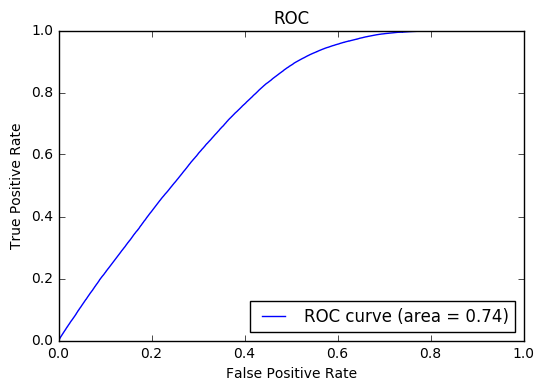

In [24]:
fpr, tpr, thresholds = roc_curve(y_validate, y_pred)

plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc_score(y_validate, y_pred))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")
plt.show()

## Подготовка

In [9]:
cv = CountVectorizer(token_pattern=r'\S+', ngram_range=(1, 3), min_df=10, binary=True, dtype=np.uint8)

In [11]:
df_all = pd.concat((df_train, df_validate))
print df_train.shape
print df_validate.shape
print df_all.shape

(7190976, 4)
(524342, 4)
(7715318, 4)


In [13]:
X_train = cv.fit_transform(df_all.response)
y_train = df_all['human-generated'].values

## Обучение

In [14]:
C = 0.01
svm = LinearSVC(penalty='l1', dual=False, C=C, random_state=55)
svm.fit(X_train, y_train)

LinearSVC(C=0.01, class_weight=None, dual=False, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l1', random_state=55, tol=0.0001,
     verbose=0)

In [15]:
df_test = pd.read_csv('data/test.txt', sep='\t')
X_test = cv.transform(df_test.response)
y_pred = svm.decision_function(X_test)

In [16]:
df_res = pd.DataFrame()
df_res['id'] = df_test.id
df_res['human-generated'] = y_pred


df_res.to_csv('sub.csv', index=False)

In [27]:
import joblib

In [28]:
y_pred = joblib.load('y_pred.joblib')

In [29]:
_id = joblib.load('id.joblib')

In [32]:
y_pred[:4]

array([[ 0.85530499,  0.14469501],
       [ 0.97592652,  0.02407348],
       [ 0.82789098,  0.17210902],
       [ 0.80253026,  0.19746974]])

In [33]:
df_res = pd.DataFrame()
df_res['id'] = _id
df_res['human-generated'] = y_pred[:, 1]

df_res.to_csv('sub1.csv', index=False)